In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn import SVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.tree.export import export_graphviz
from sklearn.externals.six import StringIO 
from sklearn.preprocessing import StandardScaler

%time

Wall time: 0 ns


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Data exploration

In [2]:
#path to directory with the relevant files
path_dir = r'..\dataset'
fname = 'final_dataset'
file_path = (os.path.join(path_dir, fname))
df = pd.read_csv(file_path,  engine = 'python' )

In [3]:
# explore the data
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,0,1,2,3,4,5,6,...,174,175,176,177,178,179,device,asym,num_peaks,Q
0,0,0,0,13.723515,-0.728629,-12.483423,1.688098,9.888614,-2.080968,-6.681533,...,-0.001162,0.000104,0.000681,0.000552,-0.000346,-0.001278,fbg,2.822111,1,6829.429046
1,1,0,0,11.469369,-6.352077,-0.006682,0.370258,1.178802,-0.449753,-0.147980,...,-0.003236,0.002370,-0.002129,-0.001926,-0.000807,-0.005789,fbg,0.742727,1,7223.116034
2,2,0,0,9.615106,-6.869292,1.914732,0.731908,-0.577569,-0.083338,0.113260,...,0.012563,-0.046946,0.010126,0.059438,-0.050124,-0.042446,fbg,0.415773,1,6902.941217
3,3,0,0,21.564599,-16.958455,8.033247,-1.398305,-0.575436,0.038131,0.151038,...,-0.000088,-0.000094,-0.000092,-0.000088,-0.000098,-0.000087,fbg,0.983101,1,1630.158028
4,4,0,0,10.607961,-8.419459,4.361642,-0.784203,-0.840003,0.674981,-0.044114,...,-0.000603,-0.001028,-0.001444,-0.000508,-0.000681,-0.001837,fbg,0.860707,1,5849.494425


In [4]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', '0', '1', '2', '3', '4',
       '5', '6',
       ...
       '174', '175', '176', '177', '178', '179', 'device', 'asym', 'num_peaks',
       'Q'],
      dtype='object', length=187)

In [5]:
df.num_peaks.value_counts()

1    125
3     21
4     20
8      8
2      8
5      4
7      2
6      1
Name: num_peaks, dtype: int64

In [6]:
df.device.value_counts()

qpfs                        75
ring_resonator_multimode    65
fbg                         49
Name: device, dtype: int64

In [7]:
# simplify peak designation, you either are going to see one peak or multiple depending upon the class
for i in range(df.num_peaks.count()):
    if df.num_peaks[i] != 1:
        df.num_peaks[i] = 2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
# normalize Q variable
mean_q = df['Q'].mean()
std_q = df['Q'].std()
df['q_scale'] = (df['Q'] - mean_q)/std_q

In [9]:
# clean up data
print(df.isna().sum())
df = df.fillna(0)
df = df.iloc[:,3:]
df.drop('Q', axis=1, inplace =True)

#  df.drop('Unnamed: 0', axis=1, inplace =True)
# df.drop('Unnamed: 0.1', axis=1, inplace =True)
# df.drop('Unnamed: 0.1.1', axis=1, inplace =True)

Unnamed: 0        0
Unnamed: 0.1      0
Unnamed: 0.1.1    0
0                 0
1                 0
                 ..
device            0
asym              0
num_peaks         0
Q                 0
q_scale           0
Length: 188, dtype: int64


In [10]:
# df.iloc[:,0:10]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,device,asym,num_peaks,q_scale
0,13.723515,-0.728629,-12.483423,1.688098,9.888614,-2.080968,-6.681533,1.885390,3.472349,-1.238911,...,-0.001162,0.000104,0.000681,0.000552,-0.000346,-0.001278,fbg,2.822111,1,-0.639499
1,11.469369,-6.352077,-0.006682,0.370258,1.178802,-0.449753,-0.147980,-0.207228,-0.147831,0.161478,...,-0.003236,0.002370,-0.002129,-0.001926,-0.000807,-0.005789,fbg,0.742727,1,-0.557370
2,9.615106,-6.869292,1.914732,0.731908,-0.577569,-0.083338,0.113260,-0.021328,0.016898,0.019467,...,0.012563,-0.046946,0.010126,0.059438,-0.050124,-0.042446,fbg,0.415773,1,-0.624163
3,21.564599,-16.958455,8.033247,-1.398305,-0.575436,0.038131,0.151038,-0.001294,-0.008540,-0.015440,...,-0.000088,-0.000094,-0.000092,-0.000088,-0.000098,-0.000087,fbg,0.983101,1,-1.724132
4,10.607961,-8.419459,4.361642,-0.784203,-0.840003,0.674981,-0.044114,-0.183478,0.077214,0.015140,...,-0.000603,-0.001028,-0.001444,-0.000508,-0.000681,-0.001837,fbg,0.860707,1,-0.843925


In [11]:
df.shape

(189, 184)

In [12]:
# sns.pairplot(df)

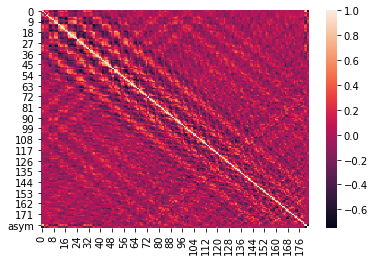

In [13]:
sns.heatmap(df.corr()[::1])

In [14]:
df.q_scale

0     -0.639499
1     -0.557370
2     -0.624163
3     -1.724132
4     -0.843925
         ...   
184    0.132485
185   -1.819782
186   -1.364425
187   -1.743910
188   -1.587837
Name: q_scale, Length: 189, dtype: float64

# Data preparation 

Features are limited to peak characterisitics only. we are going to ignore asym for now, since they way I calculated it tips the model on sensor type. 

why/how: for multimode_ring_resonator, I have spectra over the complete range of the laser. when I call skew on this dataset, I am effectively calculating the norm distribtion of the dark spectra with ring modes sitting as occassional, but large deviations. In all other spectra, the scan window was narrowly defined, because we only have one peak. as such the skew calculation end up asking how well an individual spectral resonpse deviates from normal gaussian distribution. As such the two sets of measurements are asking different questions.

for future experiments, it would be useful to calculate the skewness of peaks of an individual mode in multi sensor response, because it is a good proxy for the coupling coefficient. This way the model struggles with this feature will inform us if the underlying physics of the device is changing.

In [15]:
# define the X and y axis
# X1 = df.drop(columns = ['device'])
X1 = df[['q_scale','num_peaks']]
y1 = df.device

scaler = StandardScaler()

X_testing, X_validation, y_testing, y_validation = train_test_split(X1,y1, test_size = 0.30, random_state=42)

X_testing_scale = scaler.fit_transform(X_testing)

X_validation_scale = scaler.transform(X_validation)

X, y = X_testing_scale, y_testing



X.shape


(132, 2)

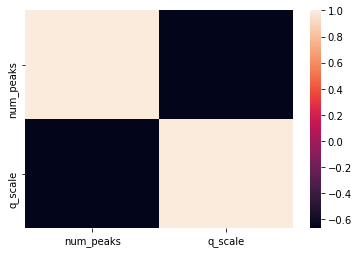

In [16]:
features =['num_peaks', 'q_scale', 'device']   
sns.heatmap(df[features].corr())

In [17]:
y_validation.value_counts()


qpfs                        23
ring_resonator_multimode    17
fbg                         17
Name: device, dtype: int64

# Running models

# run a KNN mode with gridsearch

In [18]:
# run a baseline model with no optimization

clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(X,y)
y_pred = clf.predict(X_validation_scale)

In [19]:
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9649122807017544
0.9649122807017544
0.9649122807017544
0.9649122807017544
                          precision    recall  f1-score   support

                     fbg       1.00      0.88      0.94        17
                    qpfs       0.92      1.00      0.96        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.96        57
               macro avg       0.97      0.96      0.97        57
            weighted avg       0.97      0.96      0.96        57



In [20]:
# optimize hyperparameters for a KNN modes

In [21]:
# cross-validation process using Pipeline
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)
# cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

[(3, 0.9696969696969697), (4, 0.9696969696969697), (5, 0.9772079772079773), (6, 0.9772727272727272), (7, 0.9770258980785298), (8, 0.9770220588235294), (9, 0.9767195767195768), (10, 0.976923076923077), (11, 0.9772727272727271), (12, 0.9772727272727272), (13, 0.976923076923077), (14, 0.9769841269841271), (15, 0.9768518518518519), (16, 0.9765625), (17, 0.9768907563025211), (18, 0.9771825396825398), (19, 0.9774436090225564), (20, 0.976190476190476), (21, 0.9773242630385487), (22, 0.9772727272727273), (23, 0.9768115942028986), (24, 0.9763888888888889), (25, 0.9773333333333334), (26, 0.976923076923077), (27, 0.9777777777777777), (28, 0.975), (29, 0.9758620689655173)]


In [22]:
np.argmax(cv_scores)

24

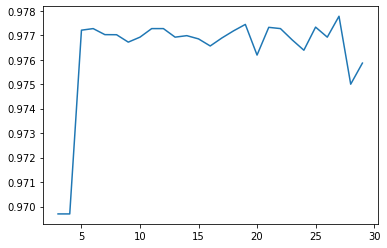

In [23]:
plt.plot(k_val, cv_scores)

we chose k = 7

In [24]:
# %time   # I am using it wrong
# create a pipeline
pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

# search for an optimal n_neighbors value using GridSearchCV
neighbors_range = list(range(2, 50))

# search or an optimal weigth parameter
weight_range = ['uniform', 'distance']

# search for an optimal leaf size
leaf_range = list(range(1,50))

# search for an optimal metric range
metric_range = ['minkowski', 'manhattan']
#create a param grid
param_grid = dict(kneighborsclassifier__n_neighbors=neighbors_range,kneighborsclassifier__leaf_size=leaf_range,
                  kneighborsclassifier__metric=metric_range, kneighborsclassifier__weights = weight_range)

# create a grid search
grid = GridSearchCV(pipe, param_grid, cv=7, scoring='f1_micro')
i
# fit the grid
grid.fit(X, y)

# view the best_score_ and best_params_
print(grid.best_score_)
print(grid.best_params_)

0.9770258980785298
{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'uniform'}


In [25]:
knn = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', leaf_size = 1, weights='uniform')
knn.fit(X,y)
y_pred = knn.predict(X_validation_scale)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))
%time

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       0.96      1.00      0.98        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.98        57
               macro avg       0.99      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57

Wall time: 0 ns


# test to see if changing CV value makes much of a difference

In [26]:
# create a pipeline
pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

# search for an optimal n_neighbors value using GridSearchCV
neighbors_range = list(range(2, 25))

# search or an optimal weigth parameter
weight_range = ['uniform', 'distance']

# search for an optimal leaf size
leaf_range = list(range(1,50))

# search for an optimal metric range
metric_range = ['minkowski', 'manhattan']
#create a param grid
param_grid = dict(kneighborsclassifier__n_neighbors=neighbors_range,kneighborsclassifier__leaf_size=leaf_range,
                  kneighborsclassifier__metric=metric_range, kneighborsclassifier__weights = weight_range)

# create a grid search
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_micro')
i
# fit the grid
grid.fit(X, y)

# view the best_score_ and best_params_
print(grid.best_score_)
print(grid.best_params_)

0.976923076923077
{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'uniform'}


In [27]:
knn = KNeighborsClassifier(n_neighbors =2, metric = 'minkowski', leaf_size = 1, weights='uniform')
knn.fit(X,y)
y_pred = knn.predict(X_validation_scale)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       0.96      1.00      0.98        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.98        57
               macro avg       0.99      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



In [28]:
# changing CV value doesn't make a big difference

In [29]:
#### need to setup onevsrestclassification with multilable bianizer

cv = 5 gives slightly better results while being computationally less demanding, i.e. 5 less folds

# Let's now build a KNN model using pipeline and randomized search grid

In [30]:
##### I need to learn to analyze this output critically beyound just getting the best params

# create a pipeline
pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

# search for an optimal n_neighbors value using GridSearchCV
neighbors_range = list(range(2, 25))

# search or an optimal weigth parameter
weight_range = ['uniform', 'distance']

# search for an optimal leaf size
leaf_range = list(range(1,50))

# search for an optimal metric range
metric_range = ['minkowski', 'manhattan']

# specify "parameter distributions"
param_dist = dict(n_neighbors=neighbors_range, leaf_size = leaf_range, metric = metric_range,weights=weight_range)

rand = RandomizedSearchCV(knn, param_dist, cv=7, scoring='f1_micro',
                          n_iter=200, random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

{'mean_fit_time': array([0.00128603, 0.00100092, 0.0007096 , 0.00042881, 0.00099966,
        0.00070538, 0.00057306, 0.0007096 , 0.00071873, 0.00070967,
        0.00071148, 0.00056549, 0.0007143 , 0.00057605, 0.00085865,
        0.00071495, 0.00085654, 0.00057013, 0.00056761, 0.00071536,
        0.00057163, 0.00043355, 0.00070936, 0.00086168, 0.00043109,
        0.00071444, 0.00084823, 0.00070517, 0.00056502, 0.0007097 ,
        0.00085599, 0.00056618, 0.00099809, 0.0008579 , 0.00085647,
        0.00099608, 0.00086706, 0.00071369, 0.00071478, 0.00057564,
        0.0008534 , 0.00070511, 0.00057214, 0.00085708, 0.00086522,
        0.00070984, 0.0007142 , 0.00070916, 0.00057415, 0.00099622,
        0.00071948, 0.00071495, 0.00071447, 0.00085742, 0.00071451,
        0.00085763, 0.00042878, 0.00071427, 0.00085739, 0.00057197,
        0.00071468, 0.0007143 , 0.00057149, 0.0005721 , 0.00071481,
        0.00085718, 0.00057149, 0.00085855, 0.0008578 , 0.00057159,
        0.00057128, 0.00042892,

In [31]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.9770258980785298
{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan', 'leaf_size': 25}


In [32]:
knn = KNeighborsClassifier(n_neighbors =3, metric = 'manhattan', leaf_size = 25, weights='uniform')
knn.fit(X,y)
y_pred = knn.predict(X_validation_scale)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9649122807017544
0.9649122807017544
0.9649122807017544
0.9649122807017544
                          precision    recall  f1-score   support

                     fbg       1.00      0.88      0.94        17
                    qpfs       0.92      1.00      0.96        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.96        57
               macro avg       0.97      0.96      0.97        57
            weighted avg       0.97      0.96      0.96        57



In [33]:
ls = list(zip(y_validation, y_pred))

# let us now create a model based on DescisionTree

In [34]:
%%time
# cross-validation process using Pipeline
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(DecisionTreeClassifier())
cv_scores =[]
k_val =[]
k_range = list(range(2,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)

[(2, 0.9696969696969697), (3, 0.9696969696969697), (4, 0.9772727272727273), (5, 0.9772079772079773), (6, 0.9772727272727272), (7, 0.9770258980785298), (8, 0.9770220588235294), (9, 0.9767195767195768), (10, 0.976923076923077), (11, 0.9772727272727271), (12, 0.9772727272727272), (13, 0.976923076923077), (14, 0.9769841269841271), (15, 0.9768518518518519), (16, 0.9765625), (17, 0.9768907563025211), (18, 0.9771825396825398), (19, 0.9774436090225564), (20, 0.976190476190476), (21, 0.9773242630385487), (22, 0.9772727272727273), (23, 0.9768115942028986), (24, 0.9763888888888889), (25, 0.9773333333333334), (26, 0.976923076923077), (27, 0.9777777777777777), (28, 0.975), (29, 0.9758620689655173)]
Wall time: 647 ms


In [35]:
np.argmax(cv_scores)

25

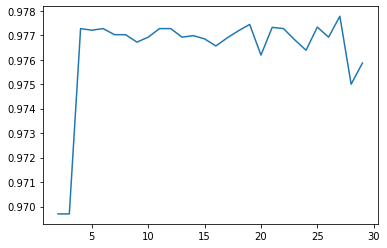

In [36]:
plt.plot(k_val, cv_scores)

cv k = 7 is the best k-fold

In [37]:
# baseline decision tree

In [38]:
clf = DecisionTreeClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_validation_scale)

In [39]:
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       0.96      1.00      0.98        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.98        57
               macro avg       0.99      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



# decision tree with gridsearchCV

In [40]:
%%time
# decision tree with grid search
# create a pipeline
pipe = make_pipeline(DecisionTreeClassifier())


# search for an optimal splitter
splitter_range = ['best','random']
                     
# search or an optimal max_depth
maxdepth_range = list(range(1,30))

# search for an optimal minimum sample size
samplesize_range = list(range(2,10))
                     
# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(2,10))

# search for an optimal of max_feature
maxfeature_range = list(range(1,3))


#create a param grid
param_grid = dict(decisiontreeclassifier__max_depth= maxdepth_range, decisiontreeclassifier__splitter= splitter_range, 
                  decisiontreeclassifier__min_samples_split=samplesize_range , 
                  decisiontreeclassifier__min_samples_leaf = sampleleaf_range, 
                  decisiontreeclassifier__max_features = maxfeature_range)



# create a grid search
grid = GridSearchCV(pipe, param_grid, cv=7, scoring='f1_micro')
i
# fit the grid
grid.fit(X, y)

# view the best_score_ and best_params_
print(grid.best_score_)
print(grid.best_params_)



0.9770258980785298
{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': 1, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_samples_split': 5, 'decisiontreeclassifier__splitter': 'best'}
Wall time: 1min 43s


In [41]:
# run the model here

dtree = DecisionTreeClassifier(splitter = 'best', max_depth =3, max_features=1, min_samples_leaf = 2, min_samples_split = 4)
dtree.fit(X,y)
y_pred = dtree.predict(X_validation_scale)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       0.96      1.00      0.98        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.98        57
               macro avg       0.99      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



# decision tree with randomized search

In [42]:
# create a pipeline
pipe = make_pipeline(DecisionTreeClassifier())

# search for an optimal splitter
splitter_range = ['best','random']
                     
# search or an optimal max_depth
maxdepth_range = list(range(1,50))

# search for an optimal minimum sample size
samplesize_range = list(range(1,50))
                     
# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(1,50))

# search for an optimal of max_feature
maxfeature_range = list(range(1,3))


# specify "parameter distributions"
param_dist = dict( splitter = splitter_range ,max_depth = maxdepth_range, min_samples_split=samplesize_range ,
                  min_samples_leaf = sampleleaf_range, max_features = maxfeature_range)

rand = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=7, scoring='f1_micro',
                          n_iter=28, random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

{'mean_fit_time': array([0.00084935, 0.00114925, 0.00143065, 0.00071583, 0.001     ,
        0.00057159, 0.00071744, 0.00057132, 0.00071474, 0.00057142,
        0.00057132, 0.0007096 , 0.00057183, 0.00071454, 0.00057152,
        0.00042857, 0.00057152, 0.00042861, 0.00057146, 0.00071454,
        0.00042861, 0.00042861, 0.00042769, 0.00042871, 0.00057135,
        0.00057197, 0.0005671 , 0.0005722 ]),
 'std_fit_time': array([0.00034689, 0.0006402 , 0.00073727, 0.00045275, 0.00053567,
        0.00049501, 0.00070556, 0.00049478, 0.00045205, 0.00049487,
        0.00049478, 0.00044901, 0.00049522, 0.00045192, 0.00049495,
        0.00049488, 0.00049495, 0.00049491, 0.00049489, 0.00045192,
        0.00049491, 0.00049491, 0.00049386, 0.00049503, 0.00049481,
        0.00049534, 0.00049121, 0.00049555]),
 'mean_score_time': array([0.00072145, 0.00085531, 0.00100538, 0.00099243, 0.00085456,
        0.00071417, 0.00056856, 0.00085718, 0.0007143 , 0.00057156,
        0.00100057, 0.00085637, 0.000856

In [43]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.9770258980785298
{'splitter': 'best', 'min_samples_split': 45, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 4}


In [44]:
dtree = DecisionTreeClassifier(splitter = 'best', min_samples_split = 45, min_samples_leaf = 2, 
                               max_features = 2, max_depth = 4)
dtree.fit(X,y)
y_pred = dtree.predict(X_validation_scale)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))


null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       0.96      1.00      0.98        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.98        57
               macro avg       0.99      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



In [45]:
# create a pipeline to test CV = 25
pipe = make_pipeline(DecisionTreeClassifier())

# search for an optimal splitter
splitter_range = ['best','random']
                     
# search or an optimal max_depth
maxdepth_range = list(range(1,50))

# search for an optimal minimum sample size
samplesize_range = list(range(1,50))
                     
# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(1,50))

# search for an optimal of max_feature
maxfeature_range = list(range(2,3))


# specify "parameter distributions"
param_dist = dict( splitter = splitter_range ,max_depth = maxdepth_range, min_samples_split=samplesize_range ,
                  min_samples_leaf = sampleleaf_range, max_features = maxfeature_range)

rand = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=25, scoring='f1_micro',
                          n_iter=28, random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

{'mean_fit_time': array([0.00084081, 0.00076138, 0.00064282, 0.00051983, 0.0005994 ,
        0.0005601 , 0.00059738, 0.0006041 , 0.00052183, 0.00056093,
        0.00056414, 0.00064294, 0.00056127, 0.00060146, 0.00064155,
        0.00076331, 0.00056127, 0.0005209 , 0.00052388, 0.00056131,
        0.00047865, 0.00060061, 0.000558  , 0.00060036, 0.00068372,
        0.00055807, 0.00055966, 0.0006402 ]),
 'std_fit_time': array([0.00046346, 0.0004279 , 0.0004822 , 0.00049944, 0.00048957,
        0.00049648, 0.00048784, 0.00049336, 0.00050141, 0.00049738,
        0.00050029, 0.00047667, 0.00049756, 0.0004912 , 0.00048123,
        0.00042904, 0.00049761, 0.0005005 , 0.00050342, 0.00049759,
        0.00049824, 0.00049041, 0.00049472, 0.00049019, 0.00046914,
        0.00049484, 0.00049627, 0.00048016]),
 'mean_score_time': array([0.00076103, 0.00079832, 0.00060021, 0.00067838, 0.00072064,
        0.00076177, 0.00056143, 0.00059838, 0.00068024, 0.00071912,
        0.00064049, 0.0007547 , 0.000562

In [46]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.9773333333333335
{'splitter': 'best', 'min_samples_split': 45, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 8}


In [47]:
dtree = DecisionTreeClassifier(splitter = 'best', min_samples_split = 45, min_samples_leaf = 2, 
                               max_features = 2, max_depth = 8)
dtree.fit(X,y)
y_pred = dtree.predict(X_validation_scale)
print(metrics.classification_report(y_validation, y_pred))

                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       0.96      1.00      0.98        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.98        57
               macro avg       0.99      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



In [48]:
feat_importance = dtree.tree_.compute_feature_importances(normalize=False)
features = dtree.tree_.feature[dtree.tree_.feature>=0] 
features

array([1, 0, 0], dtype=int64)

In [49]:
X1.columns

Index(['q_scale', 'num_peaks'], dtype='object')

# Interpetation

In [50]:
# not sure why features is giving me 3 outcomes? ah crap...is it because I kept the max_features to 2? with it being zero_indexed??

# Run a SVM model

In [51]:
clf = svm.SVC(gamma = 'auto')
clf.fit(X, y)
y_pred = clf.predict(X_validation_scale)


In [52]:
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.8596491228070176
0.8596491228070176
0.8596491228070176
0.8596491228070176
                          precision    recall  f1-score   support

                     fbg       1.00      0.53      0.69        17
                    qpfs       0.74      1.00      0.85        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.86        57
               macro avg       0.91      0.84      0.85        57
            weighted avg       0.90      0.86      0.85        57



In [53]:
# optimize SVM 

# NB model with peak characteristics as features

In [54]:
clf = GaussianNB()
clf.fit(X, y)
y_pred = clf.predict(X_validation_scale)

In [55]:
print(metrics.classification_report(y_validation, y_pred))

                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       0.96      1.00      0.98        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.98        57
               macro avg       0.99      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



# Random Forest

In [56]:
clf = RandomForestClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_validation_scale)

In [57]:
print(metrics.classification_report(y_validation, y_pred))

                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       0.96      1.00      0.98        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.98        57
               macro avg       0.99      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



# Random Forest with optimization

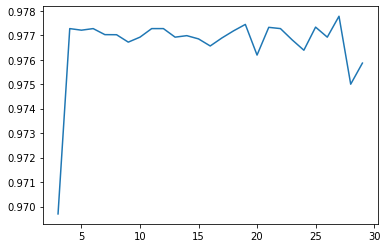

In [58]:
# cross-validation process using Pipeline

pipe = make_pipeline(RandomForestClassifier())
cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
plt.plot(k_val, cv_scores)

In [59]:
# create a pipeline
pipe = make_pipeline(RandomForestClassifier())



# search for an optimal number of estimators
estimator_range = list(range(1,100))
                     
# search or an optimal max_depth
maxdepth_range = list(range(2,50))

# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(2,50))

# search for max number of leaf nodes
maxleafnode_range = list(range(2,50))


# specify "parameter distributions"
param_dist = dict(n_estimators=estimator_range, max_depth = maxdepth_range, min_samples_leaf = sampleleaf_range,
                 max_leaf_nodes = maxleafnode_range)

rand = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=10, scoring='f1_micro',
                          random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

{'mean_fit_time': array([0.06750386, 0.05059776, 0.09269912, 0.0278975 , 0.05570066,
        0.01189613, 0.04829345, 0.08340583, 0.03440745, 0.0623951 ]),
 'std_fit_time': array([0.01051903, 0.00066252, 0.00126953, 0.00187464, 0.0026074 ,
        0.00029801, 0.00064166, 0.00180458, 0.00049243, 0.01223654]),
 'mean_score_time': array([0.00499277, 0.00400169, 0.00659952, 0.00249906, 0.0043961 ,
        0.00190027, 0.00390189, 0.00590122, 0.00299635, 0.00479729]),
 'std_score_time': array([4.54262852e-04, 1.12209064e-05, 6.62238075e-04, 5.00256574e-04,
        4.91224384e-04, 2.99386759e-04, 3.01174819e-04, 3.00484172e-04,
        1.43456679e-05, 3.98643394e-04]),
 'param_n_estimators': masked_array(data=[62, 50, 91, 26, 53, 11, 47, 81, 33, 57],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[13, 41, 20, 23, 3, 14, 33, 18, 22, 47]

In [60]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.976923076923077
{'n_estimators': 53, 'min_samples_leaf': 3, 'max_leaf_nodes': 31, 'max_depth': 46}


In [61]:
rfor = RandomForestClassifier(n_estimators = 53, min_samples_leaf = 3, max_leaf_nodes = 31, 
                                max_depth = 46)
rfor.fit(X,y)
y_pred = rfor.predict(X_validation_scale)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       0.96      1.00      0.98        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.98        57
               macro avg       0.99      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



# Conclusion: 

the dataset used here is too simiplistic to draw any firm conclusions. Model f1 scores are generally around 95%. Basically the multi-FSR spectra is easy to tell apart from qpfs and fbg based on Q factors and num_peaks feature. you could easily difference the former form the latter based on num_peaks and then you can differentiate between fbg and qpfs basedon q_scale since those two are generally very different. removing num_peaks drops your baseline KNN and SVM score to 0.75. NB drops to low 70's and Random_Forest is around high 70's. dropping Q leads to ill-defined scores.

The complexity of problem will change once I can introduce single mode resonator data. It also nees more unique qpfs data.


# Testing out min processing of data 

hypothesis we can take the spectra and with no feature extraction use it to identify the sensor type. In this case we are going to "compress" the data into a pusedo-FFT spectra. In a way this process is closer to how you would train a new person. look at the characterisitics of the spectra 

#Run models with only the fft spectra columns

In [62]:
# define the X and y axis
# X1 = df.drop(columns = ['device'])
X1 = df.iloc[:,:180]
y1 = df.device



X_testing, X_validation, y_testing, y_validation = train_test_split(X1,y1, test_size = 0.30, random_state=42)

X_scale_testing = scaler.fit_transform(X_testing)
X_scale_validation = scaler.transform(X_validation)
X, y = X_scale_testing, y_testing
X.shape

(132, 180)

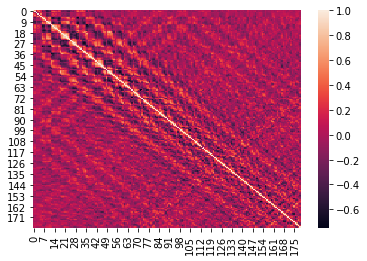

In [63]:
sns.heatmap(df.iloc[:,0:180].corr())

# Naives-Bayes Guasssian NB

In [64]:
clf = GaussianNB()
clf.fit(X, y)
y_pred = clf.predict(X_scale_validation)

In [65]:
print(metrics.classification_report(y_validation, y_pred))

                          precision    recall  f1-score   support

                     fbg       0.92      0.71      0.80        17
                    qpfs       0.85      0.96      0.90        23
ring_resonator_multimode       0.94      1.00      0.97        17

                accuracy                           0.89        57
               macro avg       0.90      0.89      0.89        57
            weighted avg       0.90      0.89      0.89        57



# Run a SVM model

In [66]:
clf = svm.SVC(gamma = 'auto')
clf.fit(X, y)
y_pred = clf.predict(X_scale_validation)

In [67]:
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.8070175438596491
0.8070175438596491
0.8070175438596491
0.8070175438596491
                          precision    recall  f1-score   support

                     fbg       1.00      0.35      0.52        17
                    qpfs       0.68      1.00      0.81        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           0.81        57
               macro avg       0.89      0.78      0.78        57
            weighted avg       0.87      0.81      0.78        57



# Run a Random KNN model

In [68]:
clf =  KNeighborsClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_scale_validation)

In [69]:
print(metrics.classification_report(y_validation, y_pred))

                          precision    recall  f1-score   support

                     fbg       0.70      0.82      0.76        17
                    qpfs       0.85      1.00      0.92        23
ring_resonator_multimode       1.00      0.59      0.74        17

                accuracy                           0.82        57
               macro avg       0.85      0.80      0.81        57
            weighted avg       0.85      0.82      0.82        57



In [70]:
# cross-validation process using Pipeline
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)
# cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

[(3, 0.7196969696969697), (4, 0.7121212121212122), (5, 0.7273504273504273), (6, 0.7272727272727272), (7, 0.7126148705096073), (8, 0.7417279411764706), (9, 0.7417989417989418), (10, 0.7428571428571429), (11, 0.7424242424242425), (12, 0.7424242424242423), (13, 0.7426573426573427), (14, 0.742857142857143), (15, 0.7425925925925926), (16, 0.7430555555555556), (17, 0.7436974789915967), (18, 0.7430555555555556), (19, 0.7418546365914787), (20, 0.7428571428571429), (21, 0.7448979591836735), (22, 0.7424242424242425), (23, 0.7420289855072465), (24, 0.7388888888888889), (25, 0.7466666666666667), (26, 0.7410256410256412), (27, 0.7444444444444445), (28, 0.7482142857142857), (29, 0.7413793103448276)]


In [71]:
np.argmax(cv_scores)

25

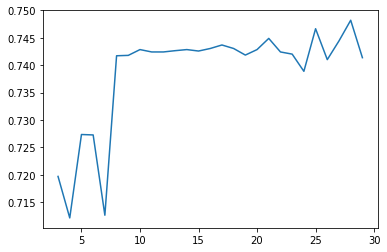

In [72]:
plt.plot(k_val, cv_scores)

In [73]:
%time
# create a pipeline
pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

# search for an optimal n_neighbors value using GridSearchCV
neighbors_range = list(range(2, 25))

# search or an optimal weigth parameter HOW DO I INTEGRATE THAT IN?
weight_range = ['uniform', 'distance']

# search for an optimal leaf size
leaf_range = list(range(1,50))

# search for an optimal metric range
metric_range = ['minkowski', 'manhattan']
#create a param grid
param_grid = dict(kneighborsclassifier__n_neighbors=neighbors_range,kneighborsclassifier__leaf_size=leaf_range,
                  kneighborsclassifier__metric=metric_range)

# create a grid search
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_micro')
i
# fit the grid
grid.fit(X, y)

# view the best_score_ and best_params_
print(grid.best_score_)
print(grid.best_params_)

Wall time: 0 ns
0.7879120879120879
{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 2}


In [74]:
knn = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', leaf_size = 1, weights='distance')
knn.fit(X,y)
y_pred = knn.predict(X_scale_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))
%time

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9298245614035088
0.9298245614035088
0.9298245614035088
0.9298245614035088
                          precision    recall  f1-score   support

                     fbg       0.81      1.00      0.89        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      0.76      0.87        17

                accuracy                           0.93        57
               macro avg       0.94      0.92      0.92        57
            weighted avg       0.94      0.93      0.93        57

Wall time: 0 ns


# Decision Tree

In [75]:
# baseline decision tree

In [76]:
clf = DecisionTreeClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_scale_validation)

In [77]:
y_pred = clf.predict(X_scale_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       0.94      1.00      0.97        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      0.94      0.97        17

                accuracy                           0.98        57
               macro avg       0.98      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



In [78]:
# cross-validation process using Pipeline
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(DecisionTreeClassifier())
cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)

[(3, 0.9621212121212123), (4, 0.9393939393939394), (5, 0.9544159544159545), (6, 0.9545454545454545), (7, 0.954469507101086), (8, 0.9466911764705882), (9, 0.9624338624338624), (10, 0.9543956043956043), (11, 0.962121212121212), (12, 0.9545454545454545), (13, 0.9468531468531469), (14, 0.9611111111111111), (15, 0.9694444444444446), (16, 0.9618055555555556), (17, 0.9548319327731093), (18, 0.9543650793650795), (19, 0.9611528822055139), (20, 0.9630952380952381), (21, 0.9546485260770975), (22, 0.9545454545454546), (23, 0.9536231884057973), (24, 0.9597222222222221), (25, 0.9626666666666667), (26, 0.9551282051282051), (27, 0.9611111111111111), (28, 0.9625000000000001), (29, 0.9620689655172413)]


In [79]:
np.argmax(cv_scores)

12

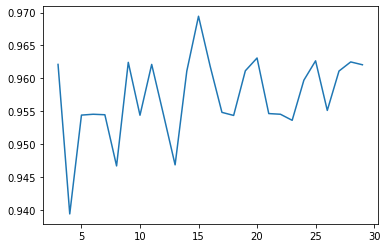

In [80]:
plt.plot(k_val, cv_scores)

# run decision tree 

In [81]:
# create a pipeline
pipe = make_pipeline(DecisionTreeClassifier())

# search for an optimal splitter
splitter_range = ['best','random']
                     
# search or an optimal max_depth
maxdepth_range = list(range(1,50))

# search for an optimal minimum sample size
samplesize_range = list(range(1,50))
                     
# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(1,50))

# search for an optimal of max_feature
maxfeature_range = list(range(1,3))


# specify "parameter distributions"
param_dist = dict( splitter = splitter_range ,max_depth = maxdepth_range, min_samples_split=samplesize_range ,
                  min_samples_leaf = sampleleaf_range, max_features = maxfeature_range)

rand = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=10, scoring='f1_micro',
                          n_iter=28, random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

{'mean_fit_time': array([0.00100467, 0.00109019, 0.00089359, 0.00070024, 0.00079999,
        0.00079637, 0.00060413, 0.00070384, 0.00109222, 0.0008065 ,
        0.00121527, 0.00130067, 0.00079875, 0.00070004, 0.00070016,
        0.00070021, 0.00070012, 0.00070004, 0.00070074, 0.00060031,
        0.00060015, 0.00050011, 0.00080013, 0.00060029, 0.00060058,
        0.00060029, 0.00079374, 0.00070403]),
 'std_fit_time': array([0.00044915, 0.00030691, 0.00053483, 0.0004587 , 0.0004    ,
        0.00039837, 0.00049338, 0.00046088, 0.00069329, 0.00060284,
        0.00076234, 0.00078138, 0.00039939, 0.00045829, 0.00045836,
        0.0004584 , 0.00045833, 0.00045829, 0.00045874, 0.00049015,
        0.00049002, 0.00050011, 0.00040007, 0.00049014, 0.00049037,
        0.00049014, 0.00039714, 0.00046107]),
 'mean_score_time': array([0.00080001, 0.00110269, 0.00071139, 0.00060394, 0.00080318,
        0.00059626, 0.00059829, 0.00069804, 0.00080512, 0.0010102 ,
        0.00089068, 0.00070333, 0.000901

In [82]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.7813186813186813
{'splitter': 'best', 'min_samples_split': 45, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 4}


In [83]:
tree = DecisionTreeClassifier(splitter = 'best', min_samples_split = 21, min_samples_leaf = 4, 
                               max_features = 2, max_depth = 17)
dtree.fit(X,y)
y_pred = dtree.predict(X_scale_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
                          precision    recall  f1-score   support

                     fbg       0.46      0.71      0.56        17
                    qpfs       0.80      0.52      0.63        23
ring_resonator_multimode       0.88      0.82      0.85        17

                accuracy                           0.67        57
               macro avg       0.71      0.68      0.68        57
            weighted avg       0.72      0.67      0.67        57



In [84]:
feat_importance = dtree.tree_.compute_feature_importances(normalize=False)
features = dtree.tree_.feature[dtree.tree_.feature>=0] 
features

array([122, 138,  28,  66,  14], dtype=int64)

In [85]:
indices = np.argsort(feat_importance)[::-1]
indices

array([122, 138,  14,  28,  66,  56,  63,  62,  61,  60,  59,  58,  57,
        55,  65,  54,  53,  52,  51,  50,  49,  48,  47,  64, 179,  45,
        67,  86,  85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,
        74,  73,  72,  71,  70,  69,  68,  46,  43,  44,  10,  19,  18,
        17,  16,  15,  13,  12,  11,   9,  21,   8,   7,   6,   5,   4,
         3,   2,   1,  20,  22,  88,  34,  42,  41,  40,  39,  38,  37,
        36,  35,  33,  23,  32,  31,  30,  29,  27,  26,  25,  24,  87,
        89, 178,  90, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146,
       145, 144, 143, 142, 141, 140, 139, 137, 136, 156, 157, 158, 169,
       177, 176, 175, 174, 173, 172, 171, 170, 168, 159, 167, 166, 165,
       164, 163, 162, 161, 160, 135, 134, 133, 100, 108, 107, 106, 105,
       104, 103, 102, 101,  99, 110,  98,  97,  96,  95,  94,  93,  92,
        91, 109, 111, 132, 123, 131, 130, 129, 128, 127, 126, 125, 124,
       121, 112, 120, 119, 118, 117, 116, 115, 114, 113,   0], d

# 
with only best features we are able to outperform baseline null-accuracy by a factor of 1.8 for f1 score of 0.78. Perhaps combing engineered features like Q and num peaks combined with these spectral features might give us better, more generalized results.

# Random Forest model

#    not optimized

In [86]:
clf = RandomForestClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_scale_validation)

In [87]:
print(metrics.classification_report(y_validation, y_pred))

                          precision    recall  f1-score   support

                     fbg       1.00      1.00      1.00        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           1.00        57
               macro avg       1.00      1.00      1.00        57
            weighted avg       1.00      1.00      1.00        57



In [88]:
# cross-validation process using Pipeline

pipe = make_pipeline(RandomForestClassifier())
cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)

[(3, 0.9772727272727272), (4, 0.9924242424242424), (5, 1.0), (6, 1.0), (7, 1.0), (8, 0.9921875), (9, 0.9925925925925926), (10, 0.9923076923076923), (11, 0.9924242424242423), (12, 0.9924242424242423), (13, 0.9923076923076923), (14, 0.9928571428571429), (15, 1.0), (16, 1.0), (17, 0.9852941176470589), (18, 0.9920634920634921), (19, 1.0), (20, 0.9928571428571429), (21, 0.9920634920634922), (22, 0.9924242424242423), (23, 0.9927536231884059), (24, 0.9833333333333334), (25, 1.0), (26, 0.9923076923076923), (27, 0.9925925925925926), (28, 0.9928571428571429), (29, 0.9913793103448276)]


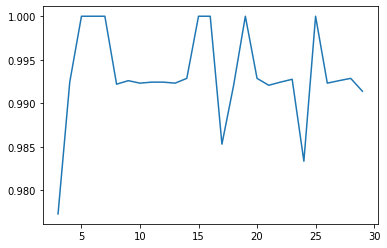

In [89]:
plt.plot(k_val, cv_scores)

In [90]:
# create a pipeline
pipe = make_pipeline(RandomForestClassifier())



# search for an optimal number of estimators
estimator_range = list(range(1,100))
                     
# search or an optimal max_depth
maxdepth_range = list(range(2,50))

# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(2,50))

# search for max number of leaf nodes
maxleafnode_range = list(range(2,50))


# specify "parameter distributions"
param_dist = dict(n_estimators=estimator_range, max_depth = maxdepth_range, min_samples_leaf = sampleleaf_range,
                 max_leaf_nodes = maxleafnode_range)

rand = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=13, scoring='f1_micro',
                          random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

{'mean_fit_time': array([0.0798477 , 0.05577364, 0.10908391, 0.03069439, 0.0727741 ,
        0.0147081 , 0.05392772, 0.09862032, 0.04084255, 0.06300514]),
 'std_fit_time': array([0.00393154, 0.00163115, 0.00185647, 0.00060579, 0.00366459,
        0.00061305, 0.0013881 , 0.00178196, 0.00102615, 0.00229457]),
 'mean_score_time': array([0.00500147, 0.00445324, 0.00676551, 0.0025338 , 0.0047638 ,
        0.00190863, 0.00406927, 0.00614916, 0.00314909, 0.00484379]),
 'std_score_time': array([0.00054604, 0.00050034, 0.00057014, 0.00049706, 0.00041843,
        0.00026449, 0.00047636, 0.00035619, 0.00035616, 0.00065543]),
 'param_n_estimators': masked_array(data=[62, 50, 91, 26, 53, 11, 47, 81, 33, 57],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[13, 41, 20, 23, 3, 14, 33, 18, 22, 47],
              mask=[False, False, False, False

In [91]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.9923076923076923
{'n_estimators': 53, 'min_samples_leaf': 3, 'max_leaf_nodes': 31, 'max_depth': 46}


In [92]:
rfor = RandomForestClassifier(n_estimators = 53, min_samples_leaf = 3, max_leaf_nodes = 31, 
                                max_depth = 46)
rfor.fit(X,y)
y_pred = rfor.predict(X_scale_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
1.0
1.0
1.0
1.0
                          precision    recall  f1-score   support

                     fbg       1.00      1.00      1.00        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           1.00        57
               macro avg       1.00      1.00      1.00        57
            weighted avg       1.00      1.00      1.00        57



#Conclusions: I am not sure what's going on with Random Forest but I probably shouldn't be using it

# Running just the best parameter

If running must the best spectral features you are looking at a f1 score of 0.69




In [93]:
selected_features = ['69','120','165', '41', '60', '70','q_scale', 'num_peaks']  #[ 69, 120, 165,  41
X1 = df[selected_features]
y1 = df.device

X1.head()

,69,120,165,41,60,70,q_scale,num_peaks
0,0.000355,0.011821,-0.001574,0.026215,0.032753,0.013746,-0.639499,1
1,-0.001252,-0.001286,-0.001189,0.002370,-0.001486,-0.001365,-0.557370,1
2,-0.000161,-0.000613,-0.015374,-0.001032,-0.001064,-0.000936,-0.624163,1
3,0.000289,-0.000120,-0.000092,-0.000056,-0.000118,-0.000395,-1.724132,1
4,-0.003869,-0.001444,-0.000732,-0.009585,0.001419,0.000630,-0.843925,1


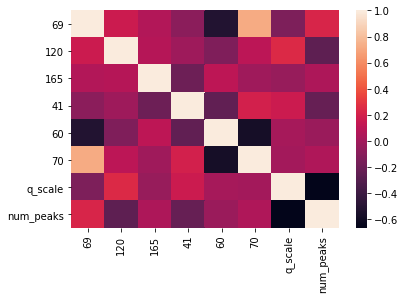

In [94]:
sns.heatmap(X1.corr())

In [95]:
# sns.pairplot(df, x_vars = X1, y_vars = df.device)  this seems to time out my patience. need to check what's going on here

In [96]:
X_testing, X_validation, y_testing, y_validation = train_test_split(X1,y1, test_size = 0.30, random_state=42)

X_testing_scale = scaler.fit_transform(X_testing)

X_validation_scale = scaler.transform(X_validation)

X, y = X_testing_scale, y_testing

In [97]:
%%time




# create a pipeline
pipe = make_pipeline(DecisionTreeClassifier())

# search for an optimal splitter
splitter_range = ['best','random']
                     
# search or an optimal max_depth
maxdepth_range = list(range(1,50))

# search for an optimal minimum sample size
samplesize_range = list(range(2,50))
                     
# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(2,50))

# search for an optimal of max_feature
maxfeature_range = list(range(1,4))


# specify "parameter distributions"
param_dist = dict( splitter = splitter_range ,max_depth = maxdepth_range, min_samples_split=samplesize_range ,
                  min_samples_leaf = sampleleaf_range, max_features = maxfeature_range)

rand = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=10, scoring='f1_micro',
                          n_iter=28, random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_


Wall time: 760 ms


{'mean_fit_time': array([0.00079632, 0.00060332, 0.00059946, 0.00050673, 0.00089319,
        0.00079684, 0.00081179, 0.00069945, 0.00090208, 0.00079222,
        0.0007937 , 0.00079823, 0.00079865, 0.00070949, 0.0007061 ,
        0.00050211, 0.00039835, 0.00069947, 0.00080411, 0.00069542,
        0.00071142, 0.00060139, 0.00070093, 0.00070515, 0.00069811,
        0.00090263, 0.0007026 , 0.0005976 ]),
 'std_fit_time': array([0.00039832, 0.00049299, 0.00048946, 0.0005069 , 0.000298  ,
        0.00039884, 0.00040623, 0.00045821, 0.00030106, 0.00039646,
        0.00039707, 0.00039923, 0.00039959, 0.00046467, 0.00046244,
        0.00050242, 0.00048792, 0.00045791, 0.00040219, 0.00045562,
        0.00046601, 0.00049105, 0.00045887, 0.00046174, 0.00045743,
        0.00030091, 0.00046013, 0.00048822]),
 'mean_score_time': array([0.00070078, 0.00079639, 0.00090308, 0.00079634, 0.00080373,
        0.00070393, 0.00078862, 0.00081031, 0.00090804, 0.00059996,
        0.00070355, 0.00059295, 0.000697

In [98]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.9230769230769231
{'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 42}


In [99]:
tree = DecisionTreeClassifier(splitter = 'best', min_samples_split = 4, min_samples_leaf = 6, 
                               max_features = 3, max_depth = 38)
dtree.fit(X,y)
y_pred = dtree.predict(X_validation_scale)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9122807017543859
0.9122807017543859
0.9122807017543859
0.9122807017543859
                          precision    recall  f1-score   support

                     fbg       0.88      0.82      0.85        17
                    qpfs       0.92      1.00      0.96        23
ring_resonator_multimode       0.94      0.88      0.91        17

                accuracy                           0.91        57
               macro avg       0.91      0.90      0.91        57
            weighted avg       0.91      0.91      0.91        57



testing out only the important features from decision tree along with Q and num_peaks you end up with a model that does as well as I would have thought. It has a relatively easy time with multi-FSR ring resonator spectra, followed by qpfs spectra. it then strugles with fbg.  

We can resonable take the two results 0.69 and 0.9 as being our bounds as we add more data. struggles with FBG are probably due to how variable the spectral response is. A single mode measurement will likely be hard to tell apart from it (Q-values will overlap). 

Overall, this experiment would sugggest that number of peaks and the peak width are the most important spectral features along with some other "frequency components". That matches intution



# Moving Forward

we need to build a frequency comb based spectrometer capable of taking taking relatively high resolution data over a broad spectral range. data then needs to be taken consistently over this range for all types of devices. 

Minimum of 70 - 100 devices for each class need to be measured. Easy for ring resonator and PhCC. going to be a tougher call for FBG sensors.

another path to pursue in the meanwhile is setup a renforced learning model and the use a more consistently taken data set to build a better classifier 